*David Schlangen, 2019-09-10*

# Corpus Objects

This notebooks explains the structure of the meta-corpus (our preprocessing of the various image and annotation corpora), and the universal API through which the *corpus objects* can be accessed.

In [1]:
# imports

from __future__ import division
import codecs
import json
# from itertools import chain, izip, permutations, combinations
# from collections import Counter, defaultdict
import configparser
import os
import random
from textwrap import fill
# import scipy
import sys
import csv
# from copy import deepcopy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Latex, display

pd.set_option('max_colwidth', 250)

In [2]:
# Load up config file (needs path; adapt env var if necessary); local imports

# load config file, set up paths, make project-specific imports
config_path = os.environ.get('VISCONF')
if not config_path:
    # try default location, if not in environment
    default_path_to_config = '../../clp-vision/Config/default.cfg'
    if os.path.isfile(default_path_to_config):
        config_path = default_path_to_config

assert config_path is not None, 'You need to specify the path to the config file via environment variable VISCONF.'        

config = configparser.ConfigParser()
with codecs.open(config_path, 'r', encoding='utf-8') as f:
    config.read_file(f)

corpora_base = config.get('DEFAULT', 'corpora_base')
preproc_path = config.get('DSGV-PATHS', 'preproc_path')
dsgv_home = config.get('DSGV-PATHS', 'dsgv_home')


sys.path.append(dsgv_home + '/Utils')
from utils import icorpus_code, plot_labelled_bb, get_image_filename, query_by_id
from utils import plot_img_cropped, plot_img_ax, invert_dict, get_a_by_b
sys.path.append(dsgv_home + '/WACs/WAC_Utils')
from wac_utils import create_word2den, is_relational
sys.path.append(dsgv_home + '/Preproc')
from sim_preproc import load_imsim, n_most_sim

sys.path.append('../Common')
from data_utils import load_dfs, plot_rel_by_relid, get_obj_bb, compute_distance_objs
from data_utils import get_obj_key, compute_relpos_relargs_row, get_all_predicate
from data_utils import compute_distance_relargs_row, get_rel_type, get_rel_instances
from data_utils import compute_obj_sizes_row

In [3]:
# Load up preprocessed DataFrames. Slow!
# These DataFrames are the result of pre-processing the original corpus data,
# as per dsg-vision/Preprocessing/preproc.py

df_names = [
            #'saiapr_bbdf',
            'mscoco_bbdf',
            'refcoco_refdf',
            #'mscoco_catsdf',
            'cococapdf',
            #'vgregdf',
            #'vgimgdf',
            #'vgreldf',
            #'vgobjdf',
            #'vgpardf', 
            #'flickr_bbdf',
            #'flickr_capdf',
            #'flickr_objdf',
            #'ade_imgdf',
            #'ade_objdf',
            #'cub_bbdf',
            #'cub_attrdf',
            #'cub_partdf',
            #'cub_capdf'
           ]
df = load_dfs(preproc_path, df_names)

## Image Objects

The most important distinction is that between *image objects*, consisting of pixel arrays, and *expression objects*, consisting of strings.

Image objects are *determined* by bounding boxes defined on images. (An implicit bounding box is the one that spans the whole image.) This information typically is found in preprocessed dataframes that have `bbdf` in their name:

In [4]:
df['mscoco_bbdf'].head()

,i_corpus,image_id,region_id,bb,cat
0,1,480023,86,"[116.95, 305.86, 285.3, 266.03]",58
1,1,50518,89,"[245.54, 208.17, 40.14, 19.1]",58
2,1,142589,93,"[288.4, 18.07, 211.6, 331.33]",58
3,1,209263,113,"[126.5, 475.24, 77.68, 76.73]",58
4,1,15307,116,"[185.57, 93.4, 219.97, 420.29]",58


The image for which the bounding box is defined is denoted by the values in `i_corpus` (a code for the image corpus), and `image_id` (which in the prototypical case ultimately translates to a filename, using additional knowledge).

`i_corpus` can be resolved from string to integer encoding (and back) as follows:

In [5]:
icorpus_code['mscoco']

1

In [6]:
icorpus_code.keys()

dict_keys(['saiapr', 'mscoco', 'saiapr_berkeley', 'mscoco_grprops', 'image_net', 'visual_genome', 'ade_20k', 'tingdataset', 'flickr_30k', 'cub_birds'])

The pair of `i_corpus, image_id` can be resolved to a filename using a utility function. This takes your config file, which in turn is where the environment variable `VISCONF` pointed to, as argument, and what you will see below will depend on that (and will most likely be different from what is here at the moment).

In [7]:
ic, ii = df['mscoco_bbdf'].iloc[0]['i_corpus image_id'.split()]
get_image_filename(config, ic, ii)

'/Volumes/SSD_500/Corpora/External/ImageCorpora/MSCOCO/COCO/train2014/COCO_train2014_000000480023.jpg'

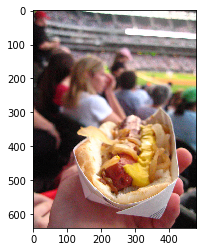

In [8]:
plt.imshow(plt.imread(get_image_filename(config, ic, ii)))

Each image is an *image object* in itself. It gets interesting, though, when we have objects defined within an image, as done in the dataframe shown above.

In [9]:
df['mscoco_bbdf'].head()

,i_corpus,image_id,region_id,bb,cat
0,1,480023,86,"[116.95, 305.86, 285.3, 266.03]",58
1,1,50518,89,"[245.54, 208.17, 40.14, 19.1]",58
2,1,142589,93,"[288.4, 18.07, 211.6, 331.33]",58
3,1,209263,113,"[126.5, 475.24, 77.68, 76.73]",58
4,1,15307,116,"[185.57, 93.4, 219.97, 420.29]",58


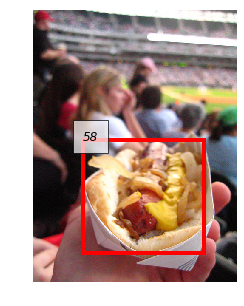

In [10]:
ic, ii, bb, cat = df['mscoco_bbdf'].iloc[0]['i_corpus image_id bb cat'.split()]
plot_labelled_bb(get_image_filename(config, ic, ii), [(bb, cat)], figsize=(5,5))

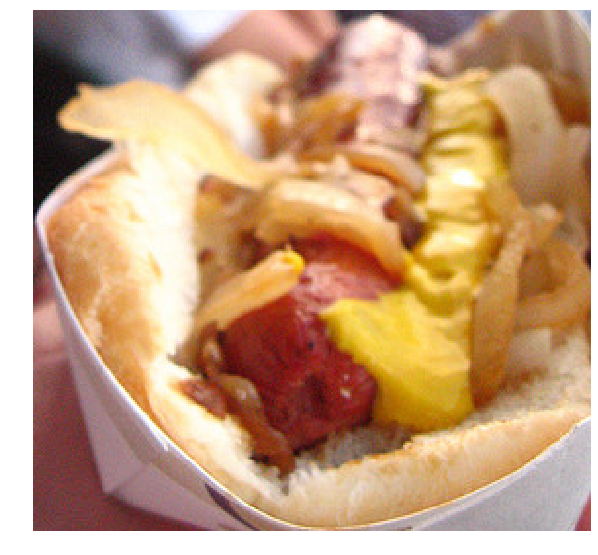

In [11]:
plot_img_cropped(get_image_filename(config, ic, ii), [int(e) for e in bb]);

(There are several functions that basically wrap `imread()` and `imshow()`, see `utils.py`.)

The additional identifier `region_id` (which is what it is called in most DFs) together with the image identification pair makes the image object uniquely addressable: `(i_corpus, image_id, region_id)`.

## Expression Objects

Expression objects are found in the `refdf` and `capdf` dataframes. Here, each row is an expression object. The value of the corpora, of course, comes from the linking between image and expression objects. This is expressed by the ID pair or triple associated with each expression object:

In [12]:
df['cococapdf'].head()

,caption,id,image_id,i_corpus
0,A very clean and well decorated empty bathroom,48,318556,1
1,A panoramic view of a kitchen and all of its appliances.,67,116100,1
2,A blue and white bathroom with butterfly themed wall tiles.,126,318556,1
3,A panoramic photo of a kitchen and dining room,148,116100,1
4,A graffiti-ed stop sign across the street from a red car,173,379340,1


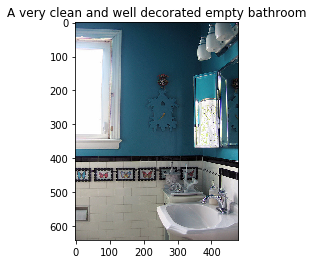

In [13]:
ic, ii, cap = df['cococapdf'].iloc[0]['i_corpus image_id caption'.split()]
plt.imshow(plt.imread(get_image_filename(config, ic, ii)))
plt.title(cap);

Images can be found directly via the ID pair; objects within images only via lookup in the dataframe that holds the bounding box:

In [14]:
df['refcoco_refdf'].head()

,i_corpus,image_id,region_id,r_corpus,rex_id,refexp,tagged
0,1,581857,1719310,refcoco,0,the lady with the blue shirt,"[[the, DT], [lady, NN], [with, IN], [the, DT], [blue, NN], [shirt, NN]]"
1,1,581857,1719310,refcoco,1,lady with back to us,"[[lady, NN], [with, IN], [back, NN], [to, TO], [us, PRP]]"
2,1,581857,1719310,refcoco,2,blue shirt,"[[blue, JJ], [shirt, NN]]"
3,1,581857,463958,refcoco,3,woman in gray shirt facing camera on right,"[[woman, NN], [in, IN], [gray, JJ], [shirt, NN], [facing, VBG], [camera, NN], [on, IN], [right, NN]]"
4,1,581857,463958,refcoco,4,woman gray right,"[[woman, NN], [gray, NN], [right, NN]]"


In [15]:
ic, ii, ri, rex = df['refcoco_refdf'].iloc[0]['i_corpus image_id region_id refexp'.split()]

In [16]:
query_by_id(df['mscoco_bbdf'], (ic, ii, ri))

,i_corpus,image_id,region_id,bb,cat
453971,1,581857,1719310,"[103.93, 299.99, 134.22, 177.42]",1


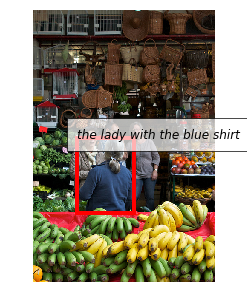

In [17]:
bb = query_by_id(df['mscoco_bbdf'], (ic, ii, ri))['bb'].tolist()[0]
plot_labelled_bb(get_image_filename(config, ic, ii), [(bb, rex)], figsize=(5,5))

While some expression frames have their own ID as well, the best way to denote an individual expression is via a pair of `(name of DataFrame, row number, column)`.

E.g., `(refcoco_refdf, 14, refexp)` would then refer to:

In [18]:
frm = "refcoco_refdf"
rown = 14
column = "refexp"
df[frm].iloc[rown][column]

'woman under suitcase'